## Step 1: Import Libraries and Load Dataset

### Description:
This step involves importing the required libraries and loading the dataset to get an overview of its structure.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
# The dataset has 216772 entried and 17 columns
# Target variable: Base MSRP and Predictors: Model Year, Make, Model, Electric range, Electric vehicle type, etc.
ev_data = pd.read_csv('/Users/poornimapatil/Downloads/Electric_Vehicle_Population_Data-3.csv')

# Quick overview of the dataset
print(ev_data.head())
print()
print()
print(ev_data.info())
print()
print()
print(ev_data.describe())

   VIN (1-10)    County       City State  Postal Code  Model Year        Make  \
0  1N4AZ0CP8D      King  Shoreline    WA      98177.0        2013      NISSAN   
1  5YJSA1E45K      King    Seattle    WA      98112.0        2019       TESLA   
2  WVGUNPE28M    Kitsap     Olalla    WA      98359.0        2021  VOLKSWAGEN   
3  JTDKARFP6H  Thurston    Olympia    WA      98501.0        2017      TOYOTA   
4  1FADP5CU9G  Thurston    Olympia    WA      98506.0        2016        FORD   

         Model                   Electric Vehicle Type  \
0         LEAF          Battery Electric Vehicle (BEV)   
1      MODEL S          Battery Electric Vehicle (BEV)   
2         ID.4          Battery Electric Vehicle (BEV)   
3  PRIUS PRIME  Plug-in Hybrid Electric Vehicle (PHEV)   
4        C-MAX  Plug-in Hybrid Electric Vehicle (PHEV)   

   Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0            Clean Alternative Fuel Vehicle Eligible            75.0   
1            Clean A

## Step 2: Data Cleaning

### Description:
This step involves handling missing values, renaming columns, and removing duplicates to ensure data quality.


In [3]:
# Check data types
ev_data.dtypes

VIN (1-10)                                            object
County                                                object
City                                                  object
State                                                 object
Postal Code                                          float64
Model Year                                             int64
Make                                                  object
Model                                                 object
Electric Vehicle Type                                 object
Clean Alternative Fuel Vehicle (CAFV) Eligibility     object
Electric Range                                       float64
Base MSRP                                            float64
Legislative District                                 float64
DOL Vehicle ID                                         int64
Vehicle Location                                      object
Electric Utility                                      object
2020 Census Tract       

In [4]:
# Check for missing values
missing_values = ev_data.isnull().sum()
print(missing_values)

# Check for duplicates
print('Number of duplicates: ', ev_data.duplicated().sum())

VIN (1-10)                                             0
County                                                 5
City                                                   5
State                                                  0
Postal Code                                            5
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                        19
Base MSRP                                             19
Legislative District                                 451
DOL Vehicle ID                                         0
Vehicle Location                                      11
Electric Utility                                       5
2020 Census Tract                                      5
dtype: int64
Number of duplicat

In [8]:
# Insights of Data cleaning:
# The cleaned dataset now has 3307 rows and 13 columns.
# Rows like 'Base MSRP' where value was 0 were removed
# Base MSRP ranges widely from 0 to 845,000
# Missing values, Irrelevent columns are handled


# Drop irrelevant columns
columns_to_drop = ['VIN (1-10)', 'DOL Vehicle ID', 'Vehicle Location', '2020 Census Tract']
ev_data_cleaned = ev_data.drop(columns=columns_to_drop)

# Handle missing values
# For numerical columns: Impute missing values with the median
numerical_columns = ['Postal Code', 'Electric Range', 'Base MSRP', 'Legislative District']
ev_data_cleaned[numerical_columns] = ev_data_cleaned[numerical_columns].fillna(ev_data_cleaned[numerical_columns].median())

# For categorical columns: Fill missing values with "Unknown"
categorical_columns = ['County', 'City', 'Electric Utility']
ev_data_cleaned[categorical_columns] = ev_data_cleaned[categorical_columns].fillna('Unknown')

# Remove rows where 'Base MSRP' is zero as they don't contribute to price prediction
ev_data_cleaned = ev_data_cleaned[ev_data_cleaned['Base MSRP'] > 0]

# Display the cleaned dataset summary
ev_data_cleaned.info(), ev_data_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 3307 entries, 52 to 216765
Data columns (total 13 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   County                                             3307 non-null   object 
 1   City                                               3307 non-null   object 
 2   State                                              3307 non-null   object 
 3   Postal Code                                        3307 non-null   float64
 4   Model Year                                         3307 non-null   int64  
 5   Make                                               3307 non-null   object 
 6   Model                                              3307 non-null   object 
 7   Electric Vehicle Type                              3307 non-null   object 
 8   Clean Alternative Fuel Vehicle (CAFV) Eligibility  3307 non-null   object 
 9   Electric R

(None,
         Postal Code   Model Year  Electric Range      Base MSRP  \
 count   3307.000000  3307.000000     3307.000000    3307.000000   
 mean   98134.145751  2015.625643      121.029029   57087.709404   
 std     2929.686797     2.504838       90.263272   22841.615838   
 min    20152.000000  2008.000000       12.000000   31950.000000   
 25%    98052.000000  2013.000000       17.000000   39995.000000   
 50%    98125.000000  2016.000000       93.000000   59900.000000   
 75%    98373.000000  2018.000000      208.000000   69900.000000   
 max    99403.000000  2020.000000      265.000000  845000.000000   
 
        Legislative District  
 count           3307.000000  
 mean              30.078319  
 std               14.554783  
 min                1.000000  
 25%               19.000000  
 50%               34.000000  
 75%               43.000000  
 max               49.000000  )

## Step 3: Exploratory Data Analysis (EDA)

### Description:
Visualize the dataset to understand the relationships between variables and identify patterns or trends.

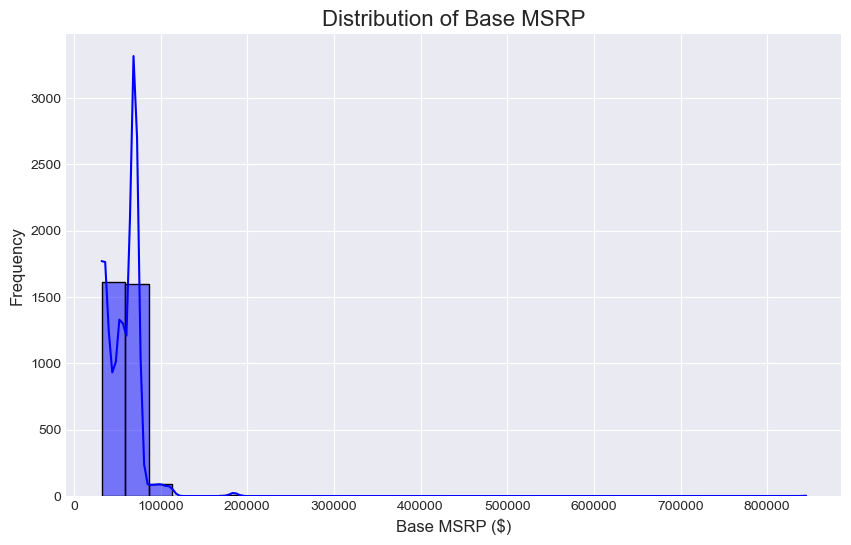

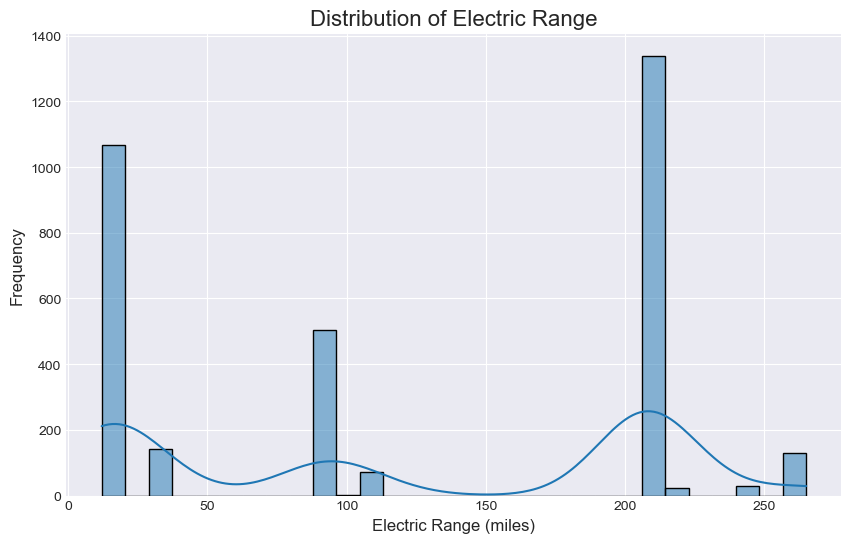

In [11]:
# Insights of EDA:
# The majority of prices are concentrated between $30,000 and $80,000.
# There are a few outliers with prices exceeding $300,000.
# Most EVs have ranges under 200 miles, with a peak around 100 miles.

# Configure visualizations
plt.style.use('seaborn-v0_8-darkgrid')

# 1: Distribution of Base MSRP
plt.figure(figsize=(10, 6))
sns.histplot(ev_data_cleaned['Base MSRP'], bins=30, kde=True, color='blue')
plt.title('Distribution of Base MSRP', fontsize=16)
plt.xlabel('Base MSRP ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 2: Distribution of Electric Range
plt.figure(figsize=(10, 6))
sns.histplot(ev_data_cleaned['Electric Range'], bins=30, kde=True)
plt.title('Distribution of Electric Range', fontsize=16)
plt.xlabel('Electric Range (miles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

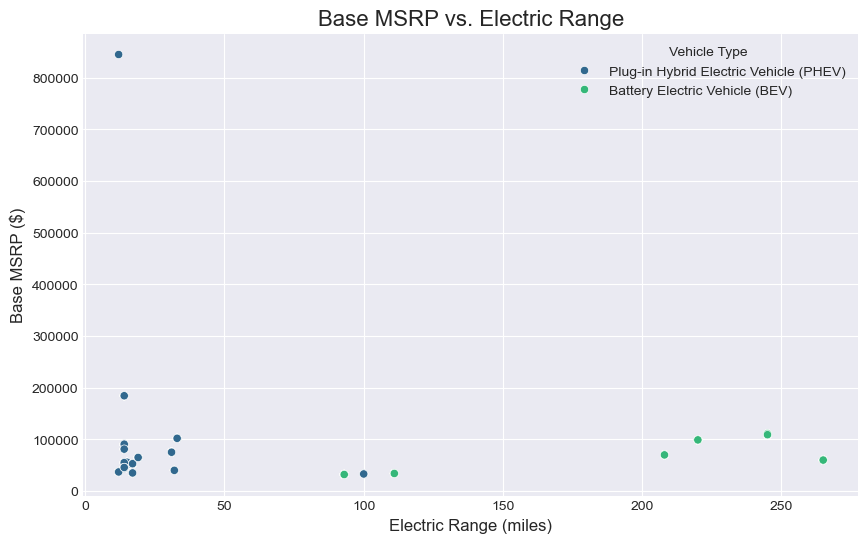

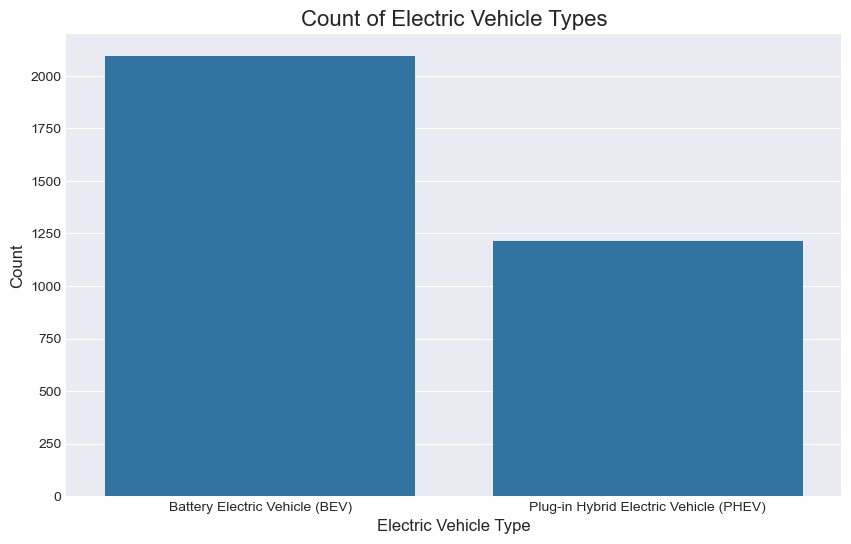

In [13]:
# There is a positive trend where vehicles with higher electric ranges tend to have higher base prices.
# BEVs dominate the dataset, followed by PHEVs

# 3: Relationship between Base MSRP and Electric Range
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Electric Range', y='Base MSRP', data=ev_data_cleaned, hue='Electric Vehicle Type', palette='viridis')
plt.title('Base MSRP vs. Electric Range', fontsize=16)
plt.xlabel('Electric Range (miles)', fontsize=12)
plt.ylabel('Base MSRP ($)', fontsize=12)
plt.legend(title='Vehicle Type')
plt.show()

# 4: Count of Electric Vehicle Types(BEV and PHEV)
plt.figure(figsize=(10, 6))
sns.countplot(data=ev_data_cleaned, x='Electric Vehicle Type', order=ev_data_cleaned['Electric Vehicle Type'].value_counts().index)
plt.title('Count of Electric Vehicle Types', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Electric Vehicle Type', fontsize=12)
plt.show()

## Step 4: Data Preprocessing

### Description:
Split the dataset into features and target, encode categorical variables, and scale numerical variables.


In [16]:
# Define features(X) and target(y)
y = ev_data_cleaned['Base MSRP']
X = ev_data_cleaned.drop(columns=['Base MSRP'])

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

df_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)


## Step 5: Model Development and Evaluation

### Description:
Build and train a machine learning model using Linear Regression and Evaluate the model's performance using metrics like MSE, MAE, and R-squared.


In [19]:
# Initialize and fit the model
liner_regression_model = LinearRegression()
liner_regression_model.fit(X_train, y_train)

# Predictions
y_pred_lr = liner_regression_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-Squared: {r2}")


Linear Regression:
Mean Squared Error: 4.444503953386639e+26
Mean Absolute Error: 2201464384274.0693
R-Squared: -1.2984607906121083e+18


## Step 6: Model Comparison and Improvement

### Description:
Train different models like Random Forest & Gradient Boosting Regressor model for comparison and analyze its performance.


In [22]:
# Random Forest

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R-Squared: {r2_rf}")

Random Forest:
Mean Squared Error: 95892124.00530589
Mean Absolute Error: 412.94932024169185
R-Squared: 0.7198513839670959


In [24]:
# Gradient Boosting Regressor Model

# Initialize and fit the model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)


print("Gradient Boosting Regressor:")
print(f"Gradient Boosting MSE: {mse_gb}")
print(f"Gradient Boosting MAE: {mae_gb}")
print(f"Gradient Boosting R^2: {r2_gb}")

Gradient Boosting Regressor:
Gradient Boosting MSE: 120359391.1319044
Gradient Boosting MAE: 1150.0356699110953
Gradient Boosting R^2: 0.6483703202746838


In [26]:
#Linear Regression performs very poorly with extremely high MSE, MAE, and a negative R². It’s clearly not a suitable model for this problem.​
#Random Forest has the best overall performance:​
#MSE is the lowest, indicating that it has the smallest error.​
#MAE is also the smallest, showing that the individual predictions are more accurate.​
#R² is the highest, meaning it explains more of the variance in the EV price.​
#Gradient Boosting has a higher MSE, MAE, and lower R² compared to Random Forest, which suggests it performs worse in this case.​

# Key Take away:​
# Random Forest is the best model among the three based on the given metrics. It has the lowest MSE, the lowest MAE, and the highest R²,
# indicating it is the most accurate and effective model for predicting EV prices.​

# Model Evaluation: Create a summary table of evaluation metrics
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting Regressor'],
    'MSE': [mse, mse_rf, mse_gb],
    'MAE': [mae, mae_rf, mae_gb],
    'R^2': [r2, r2_rf, r2_gb]
})

metrics

,Model,MSE,MAE,R^2
0,Linear Regression,4.444504e+26,2.201464e+12,-1.298461e+18
1,Random Forest,9.589212e+07,4.129493e+02,7.198514e-01
2,Gradient Boosting Regressor,1.203594e+08,1.150036e+03,6.483703e-01


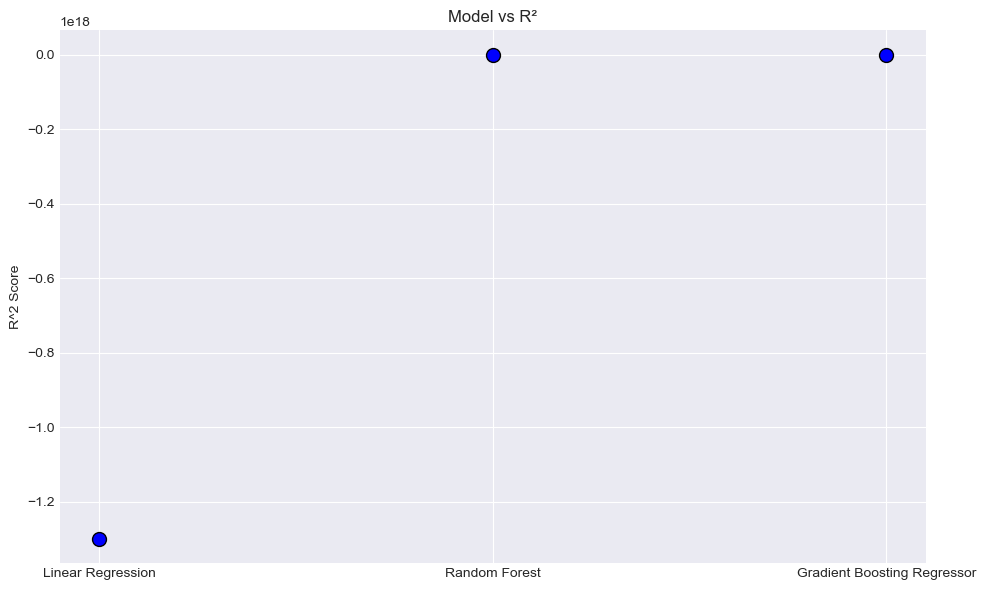

In [28]:
# comparing different models using scatter plot

# Create a Scatter plot for Model vs R^2
plt.figure(figsize=(10, 6))
plt.scatter(metrics['Model'], metrics['R^2'], color='blue', s=100, edgecolor='black')
plt.ylabel('R^2 Score')
plt.title('Model vs R²')
plt.tight_layout()
plt.show()

## Step 7: Save the Model and Visualize Results

### Description:
Save the trained model for future use and visualize the prediction results.


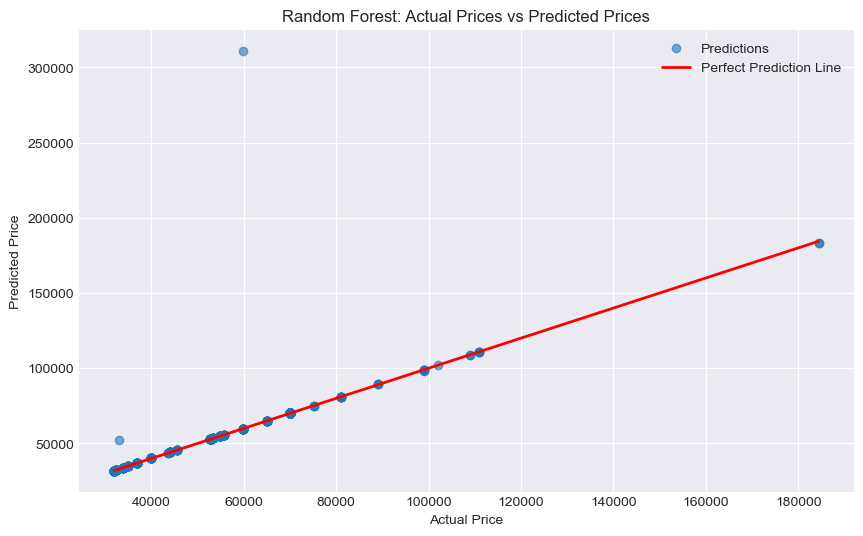

In [31]:
# Actual vs Predicted (Random forest result)

# Save the final model
import joblib
joblib.dump(rf_model, 'vehicle_price_model.pkl')

# Plotting Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label="Predictions")

# Plot a perfect prediction line (where actual price = predicted price)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label="Perfect Prediction Line")
plt.title('Random Forest: Actual Prices vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


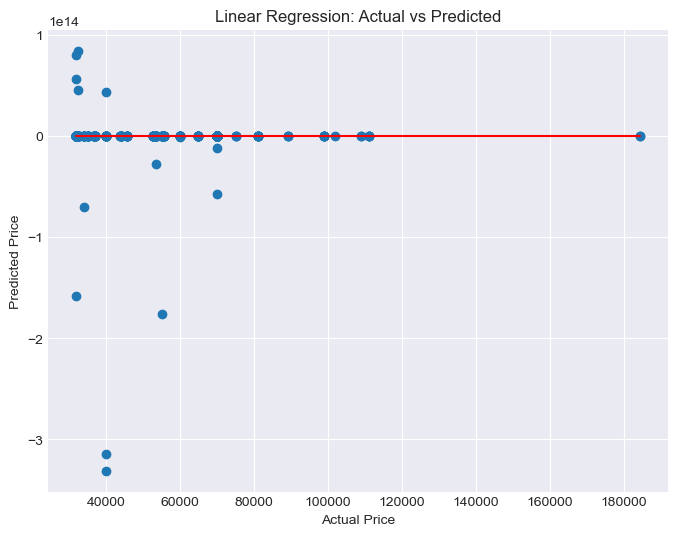

In [33]:
# Actual vs Predicted (Linear Regression Results)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

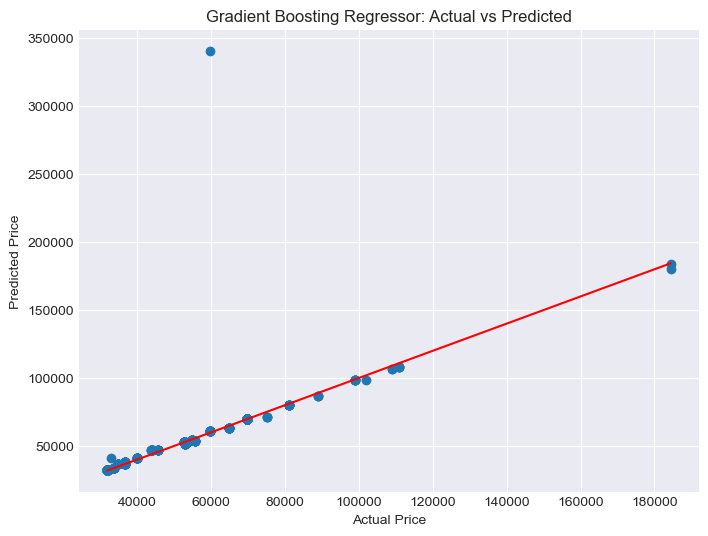

In [35]:
# Actual vs Predicted (Gradient Boosting Regressor Model Result)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('Gradient Boosting Regressor: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()